## Import Libraries & Data

In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
from math import sqrt
import collections

import jellyfish #for edit and jaro distances
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor,ExtraTreesRegressor #
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
#%inline
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


train_data = pd.read_csv('data/train.csv', encoding = "ISO-8859-1")
test_data = pd.read_csv('data/test.csv', encoding = "ISO-8859-1")
desc_data = pd.read_csv('data/product_descriptions.csv')

attrs = pd.read_csv('data/attributes.csv')




## Preprocessing Functions

In [8]:
def stem_and_lower(cell_val):
    '''
    Description: Applies stemming on specific value of a dataframe cell
                 and turns all of the letters to lowercase
    Input:       Text
    Output:      Same Text Stemmed and Lowercased 
    
    '''
    return " ".join([stemmer.stem(word) for word in cell_val.lower().split()])

def count_words(query,doc):
    '''
    Description: Finds the frequency of a query's words in a document
                 E.g. it can return the total number the words of 
                 search term appear in product title/product description
    Input:       2 Texts
    Output:      Length of the Intersection of their words 
    '''
    total=0
    cnt= (collections.Counter(doc.split()))
    for word in query.split():
        total+=cnt[str(word)]
    return total


def word_percentage(query,doc):
    '''
    Description: Finds the percentage of the words in the query tha exist in a given document 
    Input:       2 Documents
    Output:      Percentage of words of doc1 that exist in doc2
    '''
    total_query_words = len(query)
    doc_words = doc.split()
    count_words = 0
    for word in query.split():
        if word in doc_words:
            count_words += 1
    
    return count_words/total_query_words
        
    
def jaccard_coefficient(text1,text2):
    '''Finds Jaccard Similarity among 2 texts'''
    text1=set(text1.split())
    text2=set(text2.split())
    return (len(text1 & text2))/(len(text1|text2))
    
def add_product_frequency(df):
    df['product_count'] = df.groupby(['product_uid'])['id'].transform('count')
    return df

def add_product_description(df1,df2):
    '''
    Description: merging dataframes on a specific ('product_uid') key
                 in order to include product_description in query data
    Input:       2 dataframes df1,df2
    Output:      1 dataframe
    '''
    return pd.merge(df1, df2, how='left', on='product_uid')


def add_brand_name(df,brand_attrs):

    df = pd.merge(df, brand_attrs, how='left', on='product_uid')
    df = df.rename(columns={'value': 'brand_name'})
    df.fillna('unknown', inplace=True)
    return df

def add_lengths(df):
    '''Adding the lengths of some informative columns as features'''
    df['query_length'] = df['search_term'].map(lambda x:len(x.split()))
    df['title_length'] = df['product_title'].map(lambda x:len(x.split()))
    df['brand_name_length'] = df['brand_name'].map(lambda x:len(x.split()))
    df['product_description_length'] = df['product_description'].map(lambda x:len(x.split()))
    
    return df 



def add_similarity_measures(df):
    '''
    Description: add columns with search query words' appearance frequency 
                 in product_title and product_description
    Input:       dataframe 
    Output:      updated dataframe
    '''
    #dummy column in order to find title & description relevances with query
    df['query_title_description_brand'] = df['search_term']+"\t"+df['product_title']+"\t"+df['product_description']+"\t"+df['brand_name']
    
    #Check if search term words exist in product title
    df['title_includes_query'] = df['query_title_description_brand'].map(lambda x:count_words(x.split('\t')[0],x.split('\t')[1]))
    df['description_includes_query'] = df['query_title_description_brand'].map(lambda x:count_words(x.split('\t')[0],x.split('\t')[2]))
    df['brand_includes_query'] = df['query_title_description_brand'].map(lambda x:count_words(x.split('\t')[0],x.split('\t')[3]))
    
    #Check separately if the last word of the query belongs to title / description
    df['query_last_word_in_title'] = df['query_title_description_brand'].map(lambda x:count_words(x.split('\t')[0].split(" ")[-1],x.split('\t')[1]))
    df['query_last_word_in_description'] = df['query_title_description_brand'].map(lambda x:count_words(x.split('\t')[0].split(" ")[-1],x.split('\t')[2]))
    
    #Jaccard coefficient between search term-product title and search term-product_description pairs
    df['jaccard_coefficient_query_title'] = df['query_title_description_brand'].map(lambda x:jaccard_coefficient(x.split('\t')[0],x.split('\t')[1]))
    df['jaccard_coefficient_query_description'] = df['query_title_description_brand'].map(lambda x:jaccard_coefficient(x.split('\t')[0],x.split('\t')[2]))
    #Jaccard coefficient between search term-brand name
    df['jaccard_coefficient_query_brand'] = df['query_title_description_brand'].map(lambda x:jaccard_coefficient(x.split('\t')[3],x.split('\t')[0]))
    
    
    #Percentage of search term words in product title
    #df['query_percentage_in_title'] = df['query_title_description_brand'].map(lambda x:word_percentage(x.split('\t')[0],x.split('\t')[1]))
    #df['query_percentage_in_description'] = df['query_title_description_brand'].map(lambda x:word_percentage(x.split('\t')[0],x.split('\t')[2]))
    

    #Edit Distance between search term and product title('Levenshtein distance')
    df['query_title_edit_distance'] = df['query_title_description_brand'].map(lambda x:jellyfish.levenshtein_distance(x.split('\t')[0],x.split('\t')[1]))
    df['query_description_edit_distance'] = df['query_title_description_brand'].map(lambda x:jellyfish.levenshtein_distance(x.split('\t')[0],x.split('\t')[2]))
    
    
    #Jaro Distance between search term and product title('Levenshtein distance')
    df['query_title_jaro_distance'] = df['query_title_description_brand'].map(lambda x:jellyfish.jaro_distance(x.split('\t')[0],x.split('\t')[1]))
    df['query_description_jaro_distance'] = df['query_title_description_brand'].map(lambda x:jellyfish.jaro_distance(x.split('\t')[0],x.split('\t')[2]))
    
    
    df = df.drop(['query_title_description_brand'], 1)
    return df



def stem_dataset(df):
    
    '''
    Description: Stemming values of specific columns 
    Input:       Dataframe to stem
    Output:      Same Dataframe with the columns specified below
                 being modified (stemmed)
    '''
    
    # Stemming search_term,product_title,product_description,brand_name
    df['search_term'] = df['search_term'].map(lambda x:stem_and_lower(x))  #.apply(lambda x: stemmer.stem(x))
    df['product_title'] = df['product_title'].map(lambda x:stem_and_lower(x))  #.apply(lambda x: stemmer.stem(x))
    df['product_description'] = df['product_description'].map(lambda x:stem_and_lower(x)) #.apply(lambda x: stemmer.stem(x))
    df['brand_name'] = df['brand_name'].map(lambda x:stem_and_lower(x))

    return df


def preprocessing(data,desc_data,attrs,is_train):
    '''
    Description: Applies all the preprocessing functions to input dataset (train_X / test_X)
    
    Input:       data: Dataframe of dataset & 
                 desc_data: Dataframe of product description
                 is_train:  Boolean that specifies if we deal with train or test set
    Output:      Preprocessed dataset
    '''
    if is_train:
        data = train_data.drop(['relevance'], 1)
        
    #Adding product description
    data = add_product_description(data,desc_data)

    #Adding brand name from attributes
    brand_attrs = attrs[attrs.name.isin(['MFG Brand Name'])]
    brand_attrs = brand_attrs.drop(['name'],axis=1)
    data = add_brand_name(data,brand_attrs)

    

    data = add_lengths(data)

    data = add_product_frequency(data)

    data = stem_dataset(data)

    data = add_similarity_measures(data)
    
    #Drop data that won't be used in the fitting
    
    data = data.drop(['search_term','product_title','product_description','brand_name'],axis=1)
    data = data.drop_duplicates()

    return data


## Preprocess and Feature Engineering

In [9]:
#keep training labels on train_Y    
train_Y = train_data['relevance']
#preprocess train and test data
train_X = preprocessing(train_data,desc_data,attrs,True)
test_X = preprocessing(test_data,desc_data,attrs,False)



## Load Kaggle Solutions and Prepare Train/Test Set form

In [10]:
##Loading Solutions from Kaggle
sol = pd.read_csv('solution.csv')
sol_not_ign=sol[(sol['Usage'])!='Ignored']

#Prepare the form of training data
X_train = train_X.values
y_train = train_Y.values


#Add relevance label to my test_set
test_XY = pd.merge(sol_not_ign,test_X, on='id')
y_gold = test_XY['relevance'].values
X_test = (test_XY.drop(['relevance','Usage'],axis=1)).values


## Cross Validation

In [2]:
# from sklearn import pipeline, grid_search
# #rfr = RandomForestRegressor(n_estimators = 300,random_state = 2016, verbose = 1)
# gbr = GradientBoostingRegressor(random_state = 2017,subsample=0.8, verbose = 1)

# param_grid = {'n_estimators':[100,200,300],'max_depth': [3,4,5,6]}
# model = grid_search.GridSearchCV(estimator = gbr, param_grid = param_grid, n_jobs = -1,cv = 3, verbose = 20,scoring='neg_mean_squared_error')
# model.fit(X_train, y_train)

# print("Best parameters found by grid search for GBR:")
# print(model.best_params_)
# best_cv_rmse = sqrt(abs(model.best_score_))
# best_cv_rmse
# print("Best CV score (RMSE) for GBR:")
# print(best_cv_rmse)

## Models (Random Forest, Gradient Boosting,SVM etc.)

### SVM

In [ ]:
svr_model = SVR(C = 1e5, epsilon=0.2, gamma=0.5)
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)

rmse = sqrt(mean_squared_error(y_gold,y_pred)) #0.4872 
rmse

### Random Forest Regression with Bagging

In [ ]:
rf = RandomForestRegressor(n_estimators=25, random_state=0,max_depth=8)
rf_bag = BaggingRegressor(rf, n_estimators=50, random_state=0,max_samples=0.5)
rf_bag.fit(X_train, y_train)
y_pred = rf_bag.predict(X_test)

rmse = sqrt(mean_squared_error(y_gold,y_pred)) #0.4872 
rmse

### Extremely Randomized Trees

In [67]:
ert = ExtraTreesRegressor(n_estimators=200,max_depth=8,verbose=1)
ert.fit(X_train, y_train)
y_pred = ert.predict(X_test)

rmse = sqrt(mean_squared_error(y_gold,y_pred)) #0.4875 
rmse

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.1s finished


0.4883982384086174

### Gradient Bossting Regression (with / without Bagging)

In [71]:
gbr = GradientBoostingRegressor(n_estimators=300,max_depth=4,subsample=0.8, random_state = 2017, verbose = 1)
#gbr_bag = BaggingRegressor(gbr, n_estimators=80, random_state=0)

gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

rmse = sqrt(mean_squared_error(y_gold,y_pred)) #0.4840 (200 estimators)
rmse


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2780           0.0078            1.37m
         2           0.2710           0.0062            1.11m
         3           0.2660           0.0053            1.04m
         4           0.2604           0.0044           56.97s
         5           0.2572           0.0036           57.81s
         6           0.2554           0.0031            1.16m
         7           0.2525           0.0024            1.08m
         8           0.2499           0.0020            1.03m
         9           0.2480           0.0020           59.49s
        10           0.2461           0.0018           57.60s
        20           0.2364           0.0005           48.24s
        30           0.2322           0.0001           49.04s
        40           0.2309           0.0002           44.93s
        50           0.2288           0.0001           42.02s
        60           0.2284           0.0000           39.09s
       

0.48394006069815626

## Error Analysis

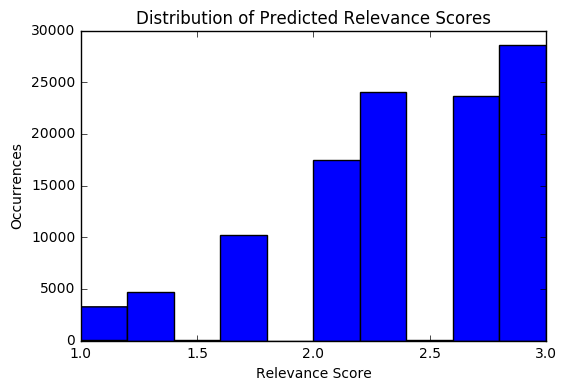

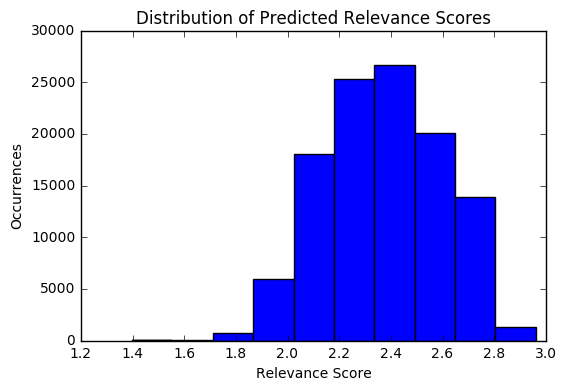

In [12]:
# plt.hist(y_gold)
# plt.title('Distribution of Predicted Relevance Scores')
# plt.xlabel('Relevance Score')
# plt.ylabel('Occurrences')
# plt.show()

# plt.hist(y_pred)
# plt.title('Distribution of Predicted Relevance Scores')
# plt.xlabel('Relevance Score')
# plt.ylabel('Occurrences')
# plt.show()

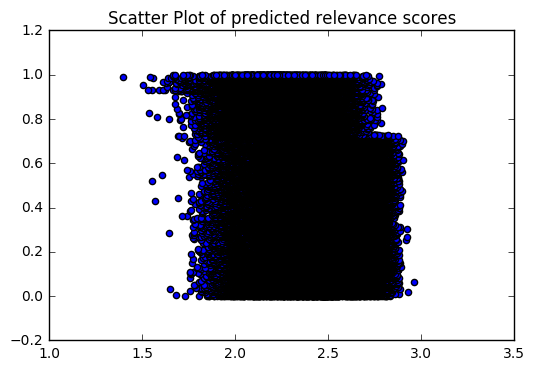

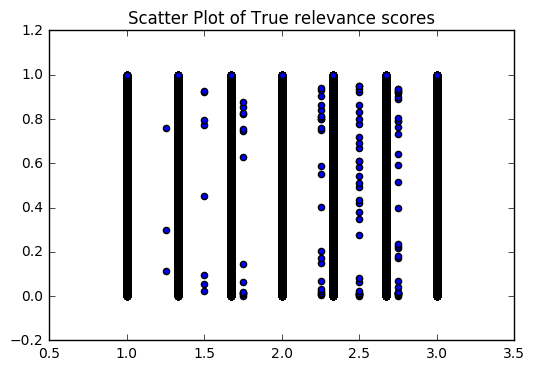

In [13]:
#plot_my_confusion_matrix(y_gold,y_pred)
#y_gold_int = y_gold.astype(int)
#y_gold_int = np.round(y_gold)
#y_pred_int = np.round(y_pred)
#plot_my_confusion_matrix(y_gold_int,y_pred_int)

# X = np.linspace(0,1,len(y_pred))
# #print(len(y_gold_int))
# plt.scatter(y_pred,X)
# plt.title('Scatter Plot of predicted relevance scores')
# plt.show()


# plt.scatter(y_gold,X)
# plt.title('Scatter Plot of True relevance scores')
# plt.show()